In [1]:
from matplotlib.colors import ListedColormap
import pystac_client

import numpy as np
import pandas as pd
import planetary_computer
import rasterio

import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt

from shapely import box
from IPython.display import Image  # To nicely display images

## Import Thomas fire perimeter

<Axes: >

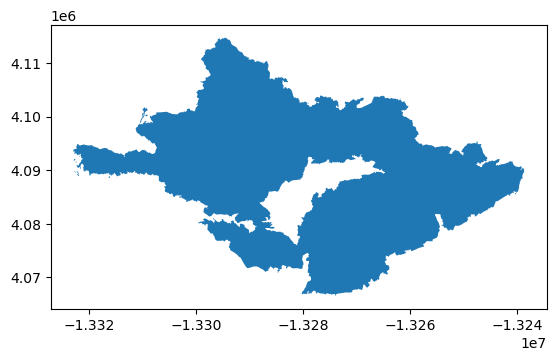

In [2]:
fire_perimeters = gpd.read_file('data/California_Fire_Perimeters_2017/California_Fire_Perimeters_2017.shp')
thomas_fire = fire_perimeters[fire_perimeters['FIRE_NAME']=='THOMAS']
thomas_fire.plot()

In [3]:
# Examine CRS of boundary
thomas_fire.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World between 85.06°S and 85.06°N.
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Retrieve LULC data over fire perimeter

In [4]:
# Open MPC data catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

In [32]:
# Reproject fire perimeter to match CRS needed for search
thomas_fire = thomas_fire.to_crs('epsg:4326')

# Create bounding box for search
bbox_of_interest = list(thomas_fire.total_bounds)

search = catalog.search(collections=["io-lulc-annual-v02"], 
                        bbox=bbox_of_interest)

# Retrieve search items
items = search.item_collection()
print(f"Returned {len(items)} Items")
items

Returned 7 Items


## Explore LULC item around Thomas Fire perimeter

In [6]:
item = items[0]  # Select item

# Display pre-rendered image
Image(url=item.assets['rendered_preview'].href)

In [7]:
# Access raster data from item
lulc23 = rioxr.open_rasterio(item.assets['data'].href)
lulc23

<xarray.DataArray (band: 1, y: 89162, x: 56684)> Size: 5GB
[5054058808 values with dtype=uint8]
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 453kB 2.166e+05 2.166e+05 ... 7.834e+05 7.834e+05
  * y            (y) float64 713kB 4.432e+06 4.432e+06 ... 3.54e+06 3.54e+06
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

Let's visually explore the extent of the `lulc23` tile relative to the CA boundary:

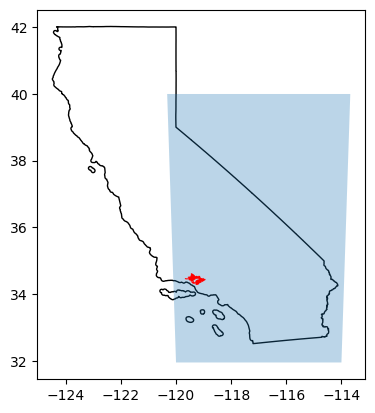

In [11]:
# Create GeoDataFrame from raster bounding box
lulc23_bbox = gpd.GeoDataFrame(geometry = [box(*lulc23.rio.bounds())],
                 crs = lulc23.rio.crs)
ca = gpd.read_file('data/ca_state_boundary/ca_state_boundary.shp')

# Plot raster boundary, fire perimeter, and CA boundary
fig, ax = plt.subplots()
ca.plot(ax=ax, color='white', edgecolor ='black')
lulc23_bbox.to_crs(ca.crs).plot(ax=ax, alpha=0.3)   # Reproject to match CA crs
thomas_fire.to_crs(ca.crs).plot(ax=ax, color='red')
plt.show()

## Clip raster to fire perimeter

First, we need to ensure our raster and fire perimeter have the same CRS.

In [12]:
thomas_fire = thomas_fire.to_crs(lulc23.rio.crs)
assert thomas_fire.crs == lulc23.rio.crs

Clipping directly with the fire perimeter is computationally expensive. It is best to first reduce with the `thomas_fire` bounding box, and then clip to the actual fire perimeter.

In [13]:
lulc23_clip = lulc23.rio.clip_box(*thomas_fire.total_bounds)

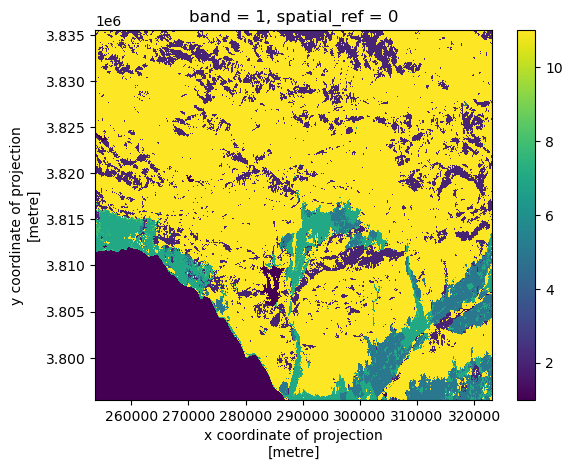

In [13]:
lulc23_clip.plot()

In [14]:
lulc_thomasfire = lulc23_clip.rio.clip(thomas_fire.geometry)

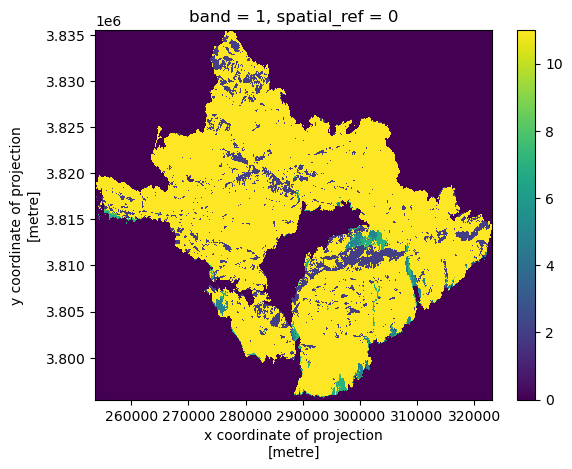

In [20]:
lulc_thomasfire.plot()

Notice the clipped areas were assigned the 0 value (instead of NA). We can check this represents no data in our raster:

In [19]:
lulc_thomasfire.rio.nodata

0

## Land cover statistics

Got class names from:
https://planetarycomputer.microsoft.com/dataset/io-lulc-annual-v02#Example-Notebook

In [19]:
# Create class_names df
class_names = pd.DataFrame({
    "category": ['No Data', 'Water', 'Trees', 'Flooded vegetation', 
                 'Crops', 'Built area', 'Bare ground', 'Snow/ice', 
                 'Clouds', 'Rangeland'],
    "code": [0, 1, 2, 4, 5, 7, 8, 9, 10, 11]
})
class_names

,category,code
0,No Data,0
1,Water,1
2,Trees,2
3,Flooded vegetation,4
4,Crops,5
5,Built area,7
6,Bare ground,8
7,Snow/ice,9
8,Clouds,10
9,Rangeland,11


In [16]:
unique_counts = np.unique(lulc_thomasfire, return_counts=True)
pix_counts = pd.DataFrame({'code':unique_counts[0], 
                           'n_pixels':unique_counts[1]})
pix_counts

,code,n_pixels
0,0,16395636
1,1,12342
2,2,1231235
3,5,153723
4,7,173495
5,8,23274
6,11,9813005


In [20]:
classes = pd.merge(left=class_names, 
                   right=pix_counts, 
                   on='code')
classes

,category,code,n_pixels
0,No Data,0,16395636
1,Water,1,12342
2,Trees,2,1231235
3,Crops,5,153723
4,Built area,7,173495
5,Bare ground,8,23274
6,Rangeland,11,9813005


In [29]:
classes['area_km2']=classes.n_pixels/1000
classes

,category,code,n_pixels,area_hectares,area_km2
0,No Data,0,16395636,16395636000,16395.636
1,Water,1,12342,12342000,12.342
2,Trees,2,1231235,1231235000,1231.235
3,Crops,5,153723,153723000,153.723
4,Built area,7,173495,173495000,173.495
5,Bare ground,8,23274,23274000,23.274
6,Rangeland,11,9813005,9813005000,9813.005


## Workflow for a single item

In [35]:

indices = [0,1,2,3,4,5]
classes = pd.DataFrame()
for i in indices:

    item = items[i]

    # Access raster data from item
    lulc = rioxr.open_rasterio(item.assets['data'].href)

    # Match fire perimeter and raster
    thomas_fire = thomas_fire.to_crs(lulc.rio.crs)
    assert thomas_fire.crs == lulc.rio.crs

    # Clip to Thomas Fire perimeter
    lulc_thomasfire = (lulc.rio.clip_box(*thomas_fire.total_bounds)
                                .rio.clip(thomas_fire.geometry))

    # Calculate number of pixels per class
    unique_counts = np.unique(lulc_thomasfire, 
                                return_counts=True)
                                
    pix_counts = pd.DataFrame({'code':unique_counts[0], 
                            'n_pixels':unique_counts[1]})
    pix_counts = pd.merge(left=class_names, 
                          right=pix_counts, 
                          on='code')  
                                                
    classes['area_km2_'+str(2017+i)]=pix_counts.n_pixels/1000                   

In [38]:
pix_counts

,category,code,n_pixels
0,No Data,0,16395636
1,Water,1,6992
2,Trees,2,318139
3,Crops,5,123895
4,Built area,7,114571
5,Bare ground,8,29616
6,Rangeland,11,10813861


In [36]:
classes

,area_km2_2017,area_km2_2018,area_km2_2019,area_km2_2020,area_km2_2021,area_km2_2022
0,16395.636,16395.636,16395.636,16395.636,16395.636,16395.636
1,12.342,6.662,6.676,8.624,9.955,6.992
2,1231.235,674.905,459.310,756.012,531.156,318.139
3,153.723,133.248,138.940,145.422,148.931,123.895
4,173.495,143.401,133.352,142.510,134.281,114.571
5,23.274,26.591,27.944,27.208,28.017,29.616
6,9813.005,10422.267,10640.852,10327.298,10554.734,10813.861


In [37]:
class_names

,category,code
0,No Data,0
1,Water,1
2,Trees,2
3,Flooded vegetation,4
4,Crops,5
5,Built area,7
6,Bare ground,8
7,Snow/ice,9
8,Clouds,10
9,Rangeland,11


In [39]:
class_colors = {
    0: "black",        # No Data
    1: "blue",         # Water
    2: "forestgreen",  # Trees
    3: "springgreen",  # Flooded vegetation
    4: "gold",         # Crops
    5: "slategrey",    # Built area
    6: "tan",          # Bare ground
    7: "azure",        # Snow/ice
    8: "pink",         # Rangeland
}

# Create a ListedColormap for the classes
cmap = ListedColormap([class_colors[key] for key in sorted(class_colors.keys())])


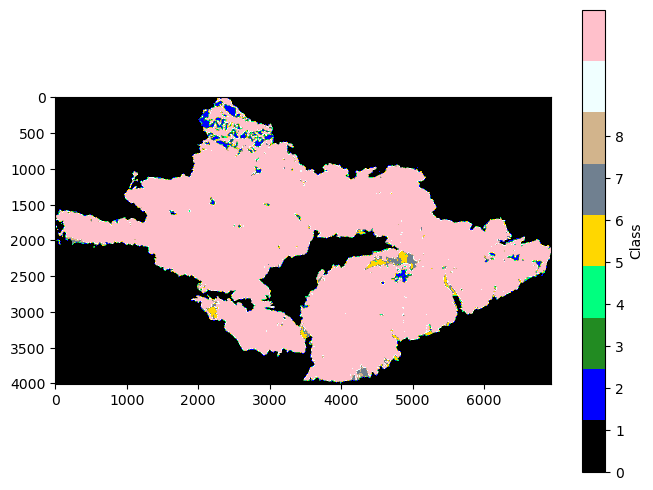

In [42]:
plt.figure(figsize=(8, 6))
plt.imshow(lulc_thomasfire.squeeze(), cmap=cmap)
plt.colorbar(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8 ], # Add class labels to the colorbar
             label="Class")  
plt.show()